<a href="https://colab.research.google.com/github/movie112/INU-DILAB/blob/main/210811_210824/popcorn_kaggle1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag of Words Meets Bags of Popcorn
### Use Google's Word2Vec for movie reviews
<https://www.kaggle.com/c/word2vec-nlp-tutorial/overview>
---


- 영화 사이트 IMDB 영화 리뷰 데이터셋 이용
- 리뷰 긍정 1 부정 0 으로 표시

## 라이브러리

In [ ]:
import pandas as pd
import seaborn as sns
import re

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize # 단어 토큰화
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
stop=set(stopwords.words('english'))

from collections import defaultdict # dictionary 생성
from collections import Counter

import string
from tqdm import tqdm   # 진행 상황

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


---

## NLP 텍스트 데이터 전처리

### 데이터
- csv(comma-separated variables): 콤마(comma)로 데이터 구분
- tsv(tab-separated values): 탭(tab)으로 데이터 구분

In [ ]:
"""
header = 0: 파일의 첫 번째 줄에 열 이름이 있음
delimiter = \t: 필드가 탭으로 구분
quoting = 3: 큰따옴표 무시
"""
train = pd.read_csv('/content/drive/MyDrive/movie-review/labeledTrainData.tsv', 
                    header=0, delimiter='\t', quoting=3)
print(train.shape)
train.head(3)

(25000, 3)


,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/movie-review/testData.tsv', 
                    header=0, delimiter='\t', quoting=3)
print(test.shape)
test.head(3)

(25000, 2)


,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."


In [ ]:
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

#### sentiment 비율
- 1(긍정리뷰), 0(부정리뷰)의 수가 같다.

1    12500
0    12500
Name: sentiment, dtype: int64


Text(0, 0.5, 'samples')

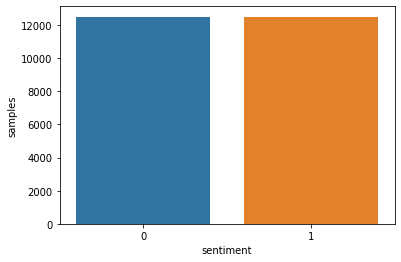

In [ ]:
sentiment_n = train.sentiment.value_counts()
print(sentiment_n)
sns.countplot(data=train, x='sentiment')
plt.gca().set_ylabel('samples')

#### review의 문자 수
- 글자 수가 0 - 3000까지 많다.
- 두 그룹 큰 차이 없지만 긍정리뷰가 글이 더 짧은 편

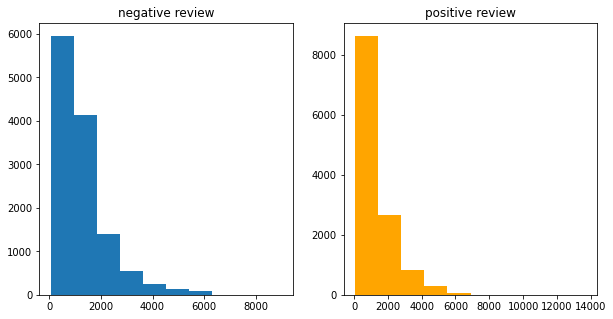

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# 부정리뷰
train_len=train[train['sentiment']==0]['review'].str.len()
ax1.hist(train_len)
ax1.set_title('negative review')
train_len=train[train['sentiment']==1]['review'].str.len()
ax2.hist(train_len, color="orange")
ax2.set_title('positive review')

plt.show()

#### 흔히 쓰이는 불용어
- 부정리뷰: 0


In [ ]:
def create_corpus(sentiment):
    corpus=[]
    
    for x in train[train['sentiment']==sentiment]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

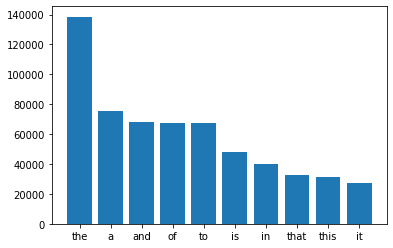

In [ ]:
corpus=create_corpus(0)

dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse = True)[:10]    # count 많은 순대로 정렬
x, y = zip(*top)
plt.bar(x, y)

- 긍정리뷰:1

<BarContainer object of 10 artists>

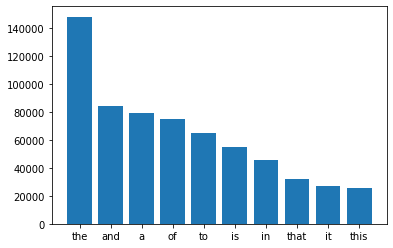

In [ ]:
corpus=create_corpus(1)

dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse = True)[:10]    # count 많은 순대로 정렬
x, y = zip(*top)
plt.bar(x, y)

- 둘 다 불용어는 비슷하게 쓰인다. the, and a of 많다

#### Punctuations
- class 0

<BarContainer object of 28 artists>

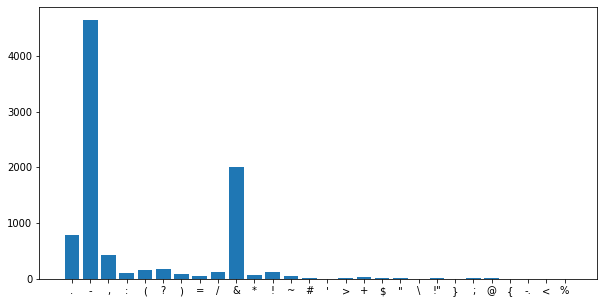

In [ ]:
plt.figure(figsize=(10,5))
corpus = create_corpus(0)

dic = defaultdict(int)
special = string.punctuation
for i in corpus:
  if i in special:
    dic[i] += 1

x, y = zip(*dic.items())
plt.bar(x, y)

<BarContainer object of 25 artists>

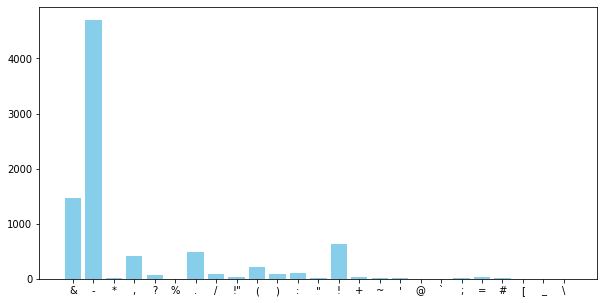

In [ ]:
plt.figure(figsize=(10,5))
corpus = create_corpus(1)

dic = defaultdict(int)
special = string.punctuation
for i in corpus:
  if i in special:
    dic[i] += 1

x, y = zip(*dic.items())
plt.bar(x, y, color='skyblue')

- '-', '&'가 많다.

#### 흔히 쓰이는 단어
- html 태그 존재

('the', 138593) a


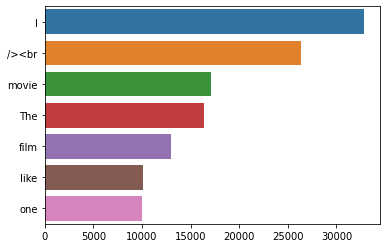

In [ ]:
corpus = create_corpus(0)
counter = Counter(corpus)

most = counter.most_common()
print(most[0], most[1][0][0]) # 빈도, 문자열만 추출

x =[]
y =[]

for word, count in most[:40]:
  if(word not in stop):   # stop = set(stopwords.words('english'))
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

#### 흔한 bigrams

In [ ]:
def get_top_bigrams(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # fit: 말뭉치를 vocabulary로 만들어주는 과정
  bag_of_words = vec.transform(corpus)    #transform: parameter를 vector로 표현해라
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

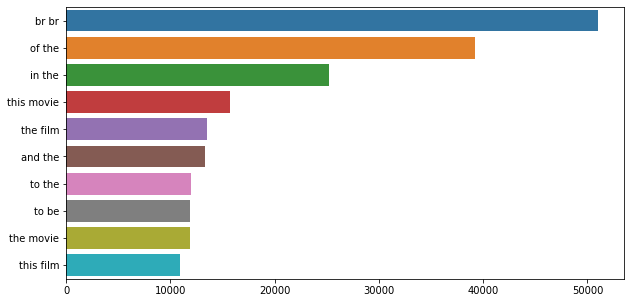

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams= get_top_bigrams(train['review'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

#### Data Cleaning

<https://programmers.co.kr/learn/courses/21/lessons/1694>

In [ ]:
def review_to_words( raw_review ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    # 4. 파이썬에서는 리스트보다 세트로 찾는 게 훨씬 빠르다.
    # stopwords 를 세트로 변환한다.
    stops = set(stopwords.words('english'))
    # 5. Stopwords 불용어 제거
    meaningful_words = [w for w in words if not w in stops]
    # 6. 어간추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return( ' '.join(stemming_words) )

In [ ]:
stemmer = nltk.stem.PorterStemmer()

clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obviou messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay 

In [ ]:
# 첫 번째 리뷰를 대상으로 전처리해줬던 내용을 전체 텍스트 데이터를 대상으로 처리한다.
# 전체 리뷰 데이터 수 가져오기
num_reviews = train['review'].size
num_reviews

25000

In [ ]:
#clean_train_reviews = []

# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))
"""
코드를 좀 더 간결하게 하려고 for loop를 사용하는
대신 apply를 사용하도록 개선
"""
# %time train['review_clean'] = train['review'].apply(review_to_words)
"""
코드는 한 줄로 간결해졌지만 여전히 오래 걸림
"""
# CPU times: user 1min 15s, sys: 2.3 s, total: 1min 18s
# Wall time: 1min 20s

In [ ]:
# 참고 : https://gist.github.com/yong27/7869662
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [ ]:
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)  

CPU times: user 546 ms, sys: 215 ms, total: 761 ms
Wall time: 1min 31s


---
## CountVectorizer로 텍스트 데이터 벡터화

#### 사이킷런의 CountVectorizer를 통해 피처 생성
- 정규표현식을 사용해 토큰을 추출
- 모두 소문자로 변환
- 의미 없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용
- min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [ ]:
# 파라메터 값만 수정해도 캐글 스코어 차이가 크게 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=20000, min_df=2,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
train_data_features = pipeline.fit_transform(clean_train_reviews)

In [ ]:
# 속도 개선을 위해 파이프라인을 사용하도록 개선
# 참고 : https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])  

In [ ]:
train_data_features.shape

(25000, 20000)

In [ ]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [ ]:
# 벡터화된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

pd.DataFrame(dist, columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,abe,abhay,abid,abigail,abil,abil make,abl,abl get,abl make,abl see,abl watch,abli,aboard,abomin,aborigin,abort,abound,abraham,abraham lincoln,abroad,abrupt,absenc,absent,absolut,absolut aw,absolut brilliant,absolut hilari,absolut horribl,absolut love,absolut noth,...,yuen,yugoslavia,yup,yuppi,yuzna,yvonn,zabriski,zabriski point,zach,zack,zane,zani,zatoichi,zealand,zelah,zelah clark,zelda,zenia,zero,zero day,zero star,zeta,zeta jone,zhang,zip,zizek,zodiac,zodiac killer,zoe,zombi,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,24,28,28,26,562,25,1259,53,32,54,35,27,37,83,69,92,63,93,29,38,136,118,83,1850,29,35,42,23,93,154,...,21,28,26,32,25,25,40,36,22,21,70,38,33,47,43,34,28,31,390,44,32,38,37,37,23,85,45,26,27,1331,23,52,37,89,161,31,71,59,40,23


In [ ]:
pd.DataFrame(train_data_features[:100].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,abe,abhay,abid,abigail,abil,abil make,abl,abl get,abl make,abl see,abl watch,abli,aboard,abomin,aborigin,abort,abound,abraham,abraham lincoln,abroad,abrupt,absenc,absent,absolut,absolut aw,absolut brilliant,absolut hilari,absolut horribl,absolut love,absolut noth,...,yuen,yugoslavia,yup,yuppi,yuzna,yvonn,zabriski,zabriski point,zach,zack,zane,zani,zatoichi,zealand,zelah,zelah clark,zelda,zenia,zero,zero day,zero star,zeta,zeta jone,zhang,zip,zizek,zodiac,zodiac killer,zoe,zombi,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---
word2vec

In [ ]:
clean_train_reviews

0        stuff go moment mj start listen music watch od...
1        classic war world timothi hine entertain film ...
2        film start manag nichola bell give welcom inve...
3        must assum prais film greatest film opera ever...
4        superbl trashi wondrous unpretenti exploit hoo...
                               ...                        
24995    seem like consider gone imdb review film went ...
24996    believ made film complet unnecessari first fil...
24997    guy loser get girl need build pick stronger su...
24998    minut documentari bu uel made earli one spain ...
24999    saw movi child broke heart stori unfinish end ...
Name: review, Length: 25000, dtype: object

---

#### Data Cleaning 예시
- 정규화(normalization), 토큰화(tokenization), 어근화(stemming), 어구 추출(phrase extraction)

##### HTML 태그 삭제
- BeautifulSoup
  - HTML 문서를 분해 분석하는 툴
  - 홈페이지 내 데이터를 쉽게 추출할 수 있도록 도와주는 파이썬 외부 라이브러리 
  - HTML 태그들을 파서(parser)를 활용해 사용하기 편한 파이썬 객체로 만들어 제공


In [ ]:
!pip install BeautifulSoup4

In [ ]:
!pip show BeautifulSoup4

Name: beautifulsoup4
Version: 4.6.3
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: google, fastai, bs4


In [ ]:
from bs4 import BeautifulSoup

example1 = BeautifulSoup(train['review'][0], "html5lib")
print(example1)

<html><head></head><body>"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br/><br/>Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br/><br/>The actual feature film bi

In [ ]:
example1.get_text()[:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [ ]:
# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [ ]:
# 모두 소문자로 변환한다.
lower_case = letters_only.lower()
# 문자를 나눈다. => 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

##### 불용어 제거(Stopword Removal)

In [ ]:
# stopwords 를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

##### 스테밍(어간추출, 형태소 분석)
- 어간 추출(stemming): 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
  - NLTK에서 제공하는 형태소 분석기를 사용. 포터 형태소 분석기는 보수적이고 랭커스터 형태소 분석기는 좀 더 적극적. 형태소 분석 규칙의 적극성 때문에 랭커스터 형태소 분석기는 더 많은 동음이의어 형태소를 생산.

In [ ]:
# 포터 스태머의 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [ ]:
# 랭커스터 스태머의 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [ ]:
# 처리 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [ ]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
# 처리 후 단어
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

##### Lemmatization 음소표기법
- 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석될 수 있도록 굴절된 형태의 단어를 그룹화하는 과정

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]
# 처리 후 단어
words[:10]

fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']